In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [3]:
sc =SparkContext()

In [4]:
spark = SparkSession(sc)

In [6]:
#1. Đọc dữ liệu => data.
# file from hdfs
# file_name = "hdfs://172.24.40.251:19000/complaints.csv"
file_name = "complaints.csv"
data = spark.read.csv(file_name, header=True, inferSchema=True)

In [7]:
#2. Cho biết dữ liệu có bao nhiêu dòng, in scheme.
# Hiển thị 3 dòng dữ liệu đầu tiên.
data.count()

2083368

In [8]:
data.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)



In [9]:
for row in data.head(3):
    print(row)
    print("\n")

Row(Date received='2019-09-24', Product='Debt collection', Sub-product='I do not know', Issue='Attempts to collect debt not owed', Sub-issue='Debt is not yours', Consumer complaint narrative='transworld systems inc. ', Company public response=None, Company=None, State=None, ZIP code=None, Tags=None, Consumer consent provided?=None, Submitted via=None, Date sent to company=None, Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complaint ID=None)


Row(Date received='is trying to collect a debt that is not mine', Product=' not owed and is inaccurate."', Sub-product=None, Issue='TRANSWORLD SYSTEMS INC', Sub-issue='FL', Consumer complaint narrative='335XX', Company public response=None, Company='Consent provided', State='Web', ZIP code='2019-09-24', Tags='Closed with explanation', Consumer consent provided?='Yes', Submitted via='N/A', Date sent to company='3384392', Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complain

In [10]:
from pyspark.sql.functions import col, udf

In [11]:
from pyspark.sql.functions import isnan, when, count, col

In [12]:
#3. Kiểm tra dữ liệu NaN, null
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,0
Issue,0
Sub-issue,0
Consumer complaint narrative,0
Company public response,0
Company,0
State,0
ZIP code,0


In [13]:
# => Không có dữ liệu NaN

In [14]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,40
Product,209258
Sub-product,511176
Issue,325183
Sub-issue,931248
Consumer complaint narrative,1454171
Company public response,1412034
Company,573431
State,597994
ZIP code,673059


In [15]:
# Có rất nhiều dữ liệu null theo từng cột

In [16]:
#4. Kiểm tra dữ liệu trùng. Xóa dữ liệu trùng.

In [17]:
num_rows = data.count()

In [18]:
num_dist_rows = data.distinct().count()

In [19]:
num_dist_rows

2020609

In [20]:
# Có dữ liệu trùng
dup_rows = num_rows - num_dist_rows

In [21]:
dup_rows

62759

In [22]:
# Xóa dữ liệu trùng
data = data.drop_duplicates()

In [23]:
data.distinct().count()

2020609

In [24]:
# Hết dữ liệu trùng

In [25]:
#5. Kiểm tra lại dữ liệu null. Tính tỉ lệ %. Xem xét cách xử lý dữ liệu null
null_data = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

In [26]:
type(null_data)

pandas.core.frame.DataFrame

In [27]:
null_data

,0
Date received,39
Product,178373
Sub-product,472168
Issue,281416
Sub-issue,884470
Consumer complaint narrative,1405173
Company public response,1353196
Company,513337
State,537111
ZIP code,611785


In [28]:
null_data["percentage"] = (null_data[0]/num_dist_rows)*100

In [29]:
null_data

,0,percentage
Date received,39,0.001930
Product,178373,8.827685
Sub-product,472168,23.367608
Issue,281416,13.927286
Sub-issue,884470,43.772447
Consumer complaint narrative,1405173,69.542054
Company public response,1353196,66.969711
Company,513337,25.405064
State,537111,26.581639
ZIP code,611785,30.277258


In [30]:
#6. Tạo dữ liệu mới, trong đó không có các cột có dữ liệu thiếu trên 30%
data_sub = data.select(["Date received", "Product",
"Sub-product", "Issue",
"Company", "State",
"Consumer consent provided?",
"Submitted via"])

In [31]:
data_sub.show(2)

+-------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|Date received|             Product|     Sub-product|               Issue|             Company|State|Consumer consent provided?|Submitted via|
+-------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|   2018-12-22|Checking or savin...|Checking account| Managing an account|NAVY FEDERAL CRED...|   SC|          Consent provided|          Web|
|   2018-12-11|Credit reporting,...|Credit reporting|Problem with a cr...|Experian Informat...|   FL|          Consent provided|          Web|
+-------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
only showing top 2 rows



In [32]:
#7. Xoá các dòng có "Date received" là null và/hoặc "Product" là null

In [33]:
data_sub = data_sub.dropna(how="any", subset=["Date received", "Product"])

In [34]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,332225
Issue,141159
Company,373348
State,397120
Consumer consent provided?,399331
Submitted via,381799


In [35]:
#8. Tạo cột "date_from_text" chứa dữ liệu yyyy-dd-mm từ "Date received" nếu có
# nếu không sẽ là ''.
# Lọc dữ liệu data_sub với yêu cầu "date_from_text" khác ''

In [36]:
from pyspark.sql import functions as F

In [37]:
data_sub = data_sub.withColumn("date_from_text",
F.regexp_extract(data_sub["Date received"],
r"(\d{4}-\d{1,2}-\d{1,2})", 0))

In [38]:
data_sub.select("date_from_text", "Date received").head(5)

[Row(date_from_text='2018-12-22', Date received='2018-12-22'),
 Row(date_from_text='2018-12-11', Date received='2018-12-11'),
 Row(date_from_text='', Date received='A secondary issue is also that they make it very difficult to set up automatic payments to have the mortgage pay early. This is a huge problem for veterans  and their dependents because they can be out of the country on XXXX and so they are taught that it is important to try to be early on your mortgage just to avoid any problems. I have tried so hard to do that with them'),
 Row(date_from_text='2019-04-24', Date received='2019-04-24'),
 Row(date_from_text='2019-02-03', Date received='2019-02-03')]

In [39]:
data_sub = data_sub.filter(data_sub["date_from_text"]!='')

In [40]:
data_sub.select("date_from_text", "Date received").head(10)

[Row(date_from_text='2018-12-22', Date received='2018-12-22'),
 Row(date_from_text='2018-12-11', Date received='2018-12-11'),
 Row(date_from_text='2019-04-24', Date received='2019-04-24'),
 Row(date_from_text='2019-02-03', Date received='2019-02-03'),
 Row(date_from_text='2019-04-08', Date received='2019-04-08'),
 Row(date_from_text='2019-04-12', Date received='2019-04-12'),
 Row(date_from_text='2019-05-09', Date received='2019-05-09'),
 Row(date_from_text='2019-08-06', Date received='2019-08-06'),
 Row(date_from_text='2019-08-21', Date received='2019-08-21'),
 Row(date_from_text='2019-02-18', Date received='2019-02-18')]

In [41]:
# 9. Tạo cột "CCP" mới lấy dữ liệu từ cột "Consumer consent provided?"
# Với cột "CCP" hãy điền "Consent not provided" thay cho null
data_sub.select(["Consumer consent provided?"]).distinct().count()

12830

In [42]:
data_sub = data_sub.withColumn("CCP", data_sub["Consumer consent provided?"])

In [43]:
data_sub = data_sub.fillna("Consent not provided", subset="CCP")

In [44]:
#10. Tạo cột "SV" mới lấy dữ liệu từ cột "Submitted via"
# Với cột "SV" hãy điền "Other" thay cho null

In [45]:
data_sub = data_sub.withColumn("SV", data_sub["Submitted via"])

In [46]:
data_sub = data_sub.fillna("Other", subset="SV")

In [47]:
#11. Tạo cột "Sub-pr" mới lấy dữ liệu từ cột "Sub-product"
# Với cột "Sub-pr" hãy điền "I do not know" thay cho null

In [48]:
data_sub = data_sub.withColumn("Sub-pr", data_sub["Sub-product"])

In [49]:
data_sub = data_sub.fillna("I do not know", subset="Sub-pr")

In [50]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
CCP,0


In [51]:
#12. Tạo cột State_new lấy giá trị từ cột State theo điều kiện sau:
# nếu có thông tin State thì lấy thông tin
# nếu không có thông tin thì điền "unknown"

In [52]:
data_sub = data_sub.withColumn('State_new',
                               when(col('State').isNull(),'unknown')
                               .otherwise(col('State')))

In [53]:
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType

In [54]:
#13. Tạo cột Date_received với dữ liệu lấy từ cột "date_from_text",
# định dạng thời gian yyyy-mm-dd .
func = udf (lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
data_sub = data_sub.withColumn('Date_received', func(col('date_from_text')))

In [55]:
data_sub.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- date_from_text: string (nullable = true)
 |-- CCP: string (nullable = false)
 |-- SV: string (nullable = false)
 |-- Sub-pr: string (nullable = false)
 |-- State_new: string (nullable = true)
 |-- Date_received: date (nullable = true)



In [56]:
data_sub.select('Date_received').show(5)

+-------------+
|Date_received|
+-------------+
|   2018-12-22|
|   2018-12-11|
|   2019-04-24|
|   2019-02-03|
|   2019-04-08|
+-------------+
only showing top 5 rows



In [57]:
#14. Tạo cột mới chứa ngày trong tuần day_of_week (1: Monday, 7: Sunday)
# với dữ liệu lấy từ cột 'Date_received'
data_sub = data_sub.withColumn('Day_of_Week', dayofweek('Date_received'))

In [58]:
from pyspark.sql.functions import year, month

In [59]:
data_sub = data_sub.withColumn('year', year('Date_received')) \
.withColumn('month', month('Date_received'))

In [60]:
data_sub.select('Date_received', 'Day_of_Week', 'month', 'year').show(5)

+-------------+-----------+-----+----+
|Date_received|Day_of_Week|month|year|
+-------------+-----------+-----+----+
|   2018-12-22|          7|   12|2018|
|   2018-12-11|          3|   12|2018|
|   2019-04-24|          4|    4|2019|
|   2019-02-03|          1|    2|2019|
|   2019-04-08|          2|    4|2019|
+-------------+-----------+-----+----+
only showing top 5 rows



In [61]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in
data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
CCP,0


In [62]:
#16. Vẽ biểu đồ thể hiện tần suất nhận complaint theo ngày trong tuần
df = data_sub.select('Day_of_Week').toPandas()

array([[<Axes: title={'center': 'Day_of_Week'}>]], dtype=object)

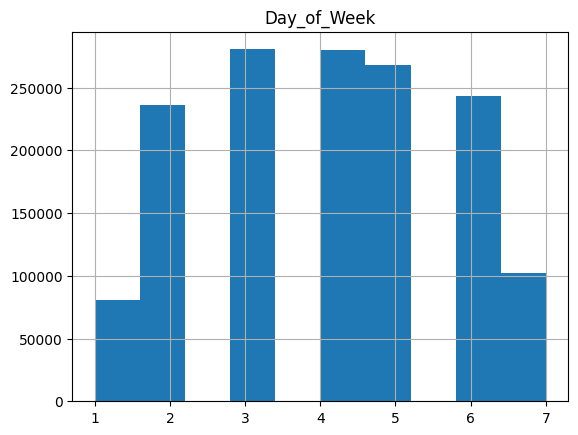

In [63]:
df.hist()

In [64]:
# Khách hàng complaint nhiều nhất vào thứ 4 và thứ 5

In [65]:
#17. Hãy cho biết 20 sản phẩm nhận complaint nhiều nhất.
# Đó là những sản phẩm nào? Biểu diễn bằng đồ thị.
df_products = data_sub.groupby('product').count().orderBy('count',
ascending=False).toPandas()

In [66]:
df_products.head(20)

,product,count
0,"Credit reporting, credit repair services, or o...",331635
1,Mortgage,295097
2,Debt collection,278961
3,Credit reporting,139825
4,Credit card,89175
5,Bank account or service,86193
6,Credit card or prepaid card,67849
7,Checking or savings account,57461
8,Student loan,56365
9,Consumer Loan,31592


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

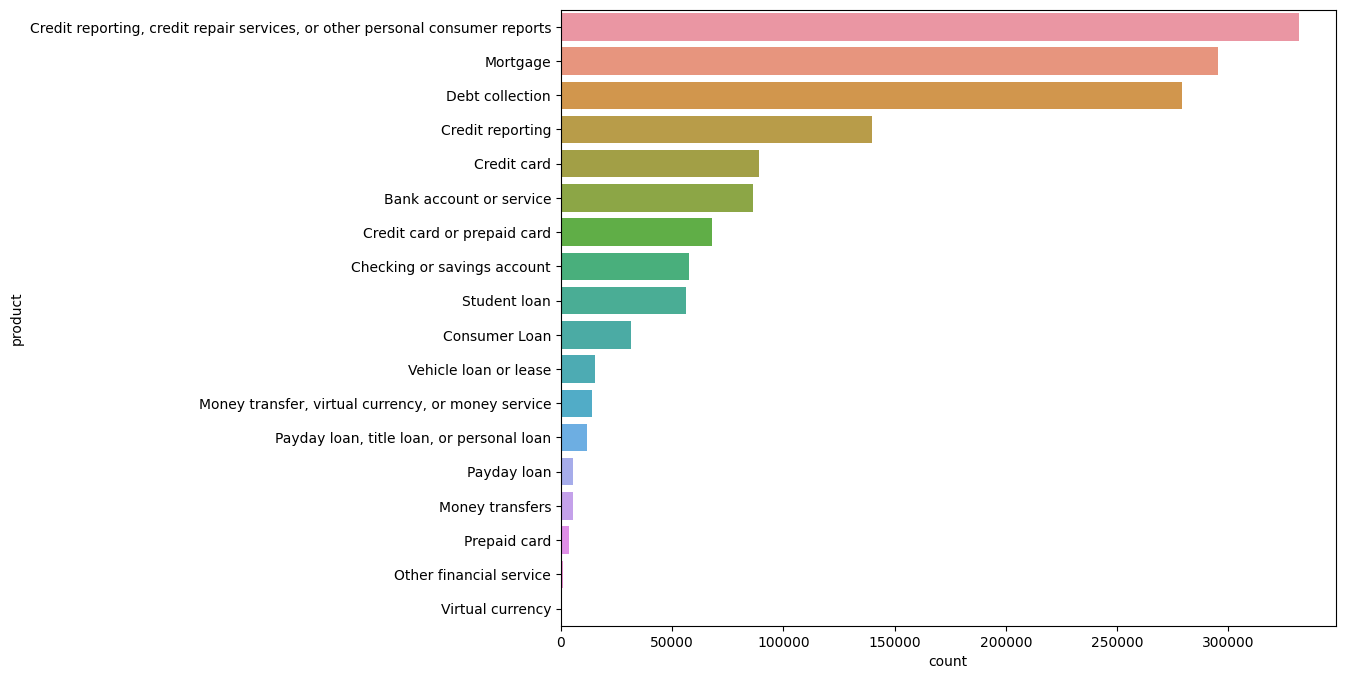

In [68]:
plt.figure(figsize=(10,8))
sns.barplot(data = df_products, x="count", y="product", )
plt.show()